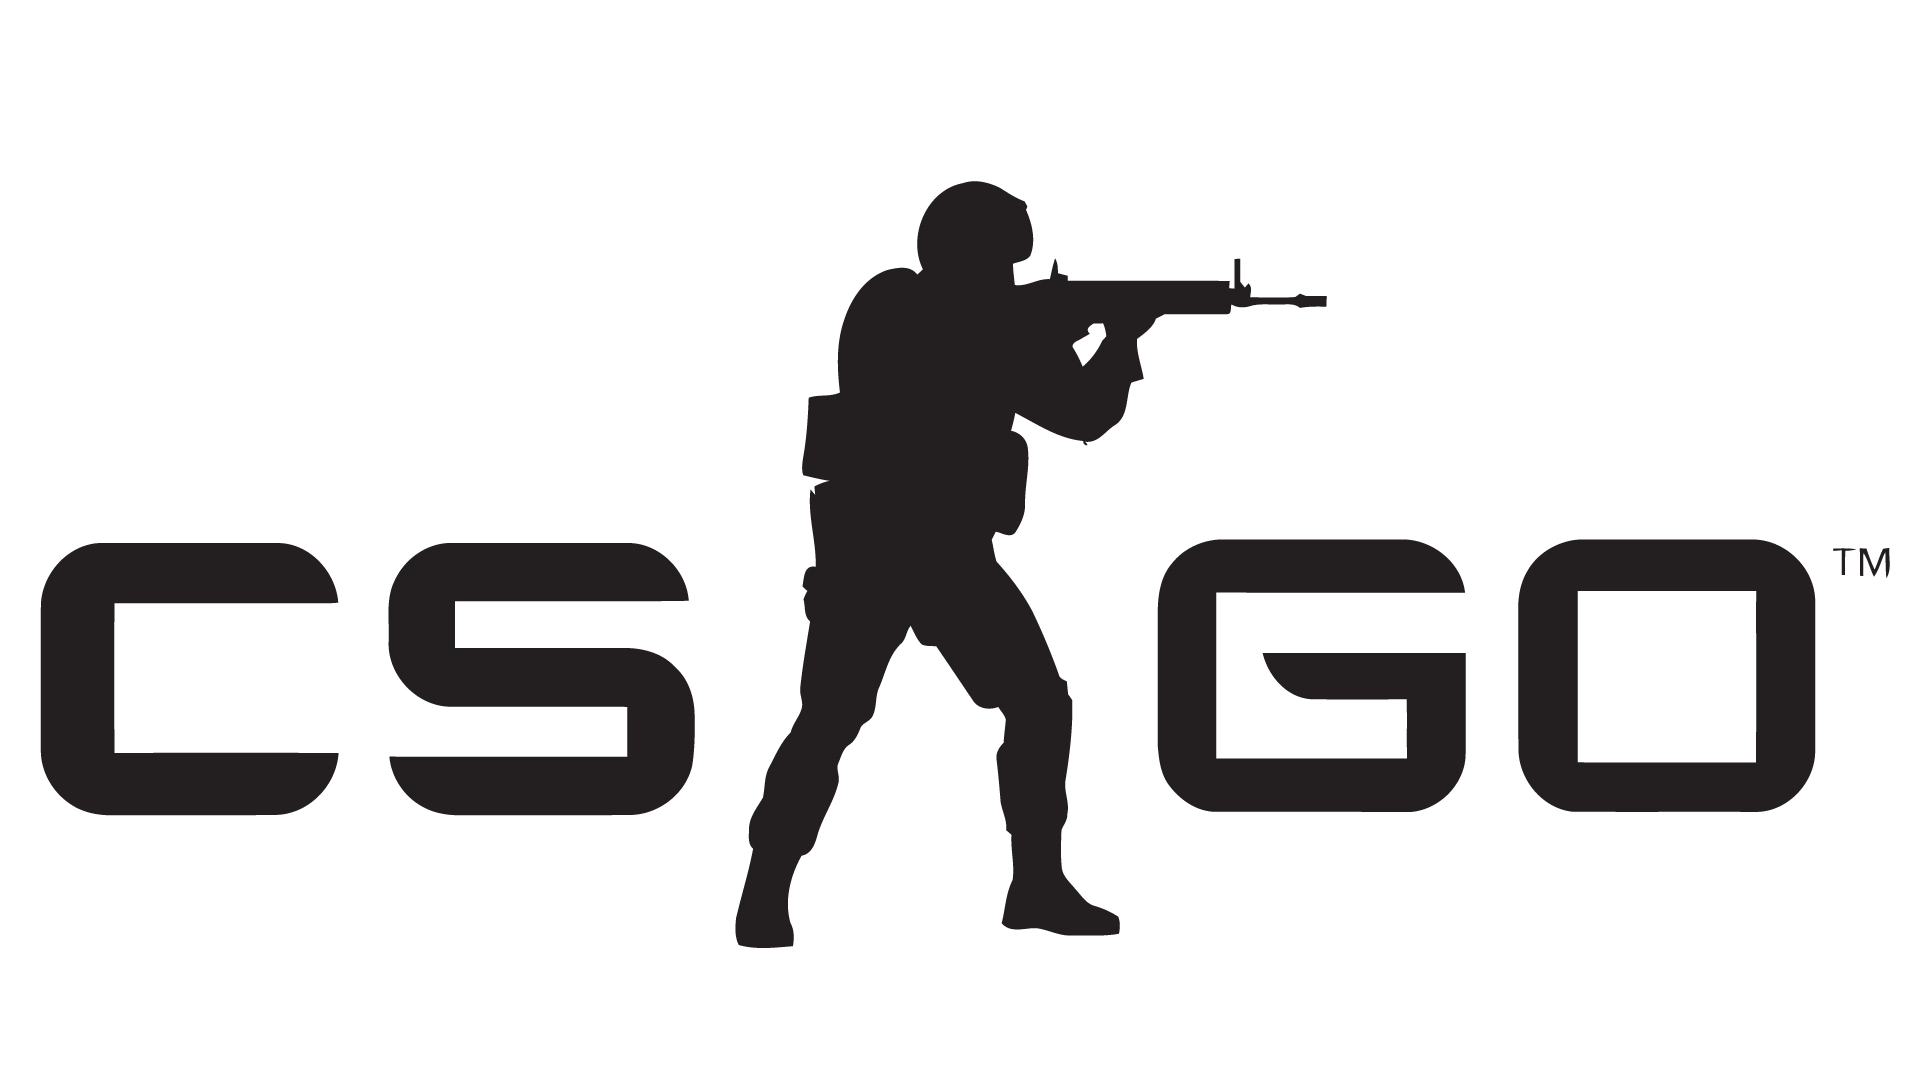



#<center>Analyzing Playstyles and Mechanics of Counter Strike Using Python</center>

<center>Alec Pool and Matt Durkin</center>



**Background:**
[Counter Strike: Global Offensive](https://store.steampowered.com/app/730/CounterStrike_Global_Offensive/) is a video game in which teams of 5 compete to win matches that consist of 30 individual rounds. The players are split into two teams of “Terrorist” and “Counter-Terrorist”, in which the Terrorist team can win by detonating a bomb at one of two ‘sites’ or eliminating all of the other team, and Counter-Terrorists can win by defusing the terrorists’ bomb or eliminating all of the other team. Games are split into two halves of 15 rounds each, and each team spends one half as the Terrorists and one half as the Counter-Terrorists. 

At the end of each round, each player is rewarded a certain amount of in-game money based on their actions in the round (kills, planting the bomb, etc), the winning team of the round, and the results of the preceding rounds (for example: losing your fifth round in a row will grant the losing team \$3400 per player, where as losing only one round will grant each player just \$1400). This money is then used in the next round to purchase equipment (weapons, grenades, armor, etc). As the game progresses, teams can afford stronger weapons and more grenades/armor. Each teams buying strategies at the beginning of a round are categorized as follows:

  -Pistol Round - The first round of each half where each team has only $800 per player and can not afford to buy anything stronger than a pistol or grenades.

  -Eco Round/Semi-Eco Round - When one team does not have enough money for a full buy and chooses to save most or all of their cash in the hopes of going into the following rounds with a better economy in which they can buy full loadouts. 
  
  -Force Buy - When one team does not have enough money for a full buy and chooses to spend it all on whatever they can afford. This will usually consist of them buying only the cheaper, less powerful rifles or SMGs. 

  -Full Buy/Normal Buy - When a team has enough money to afford the ‘best’ weapons and does not go out of their way to save for future rounds.

  The weapons of Counter-Strike are split into 5 categories: Heavy (Shotguns and LMGs), Rifles, Snipers, Pistols, and SMGs. When players can afford to do so, they will usually buy rifles (AK47 or M4) and snipers (AWP).

  [More info on Counter Strike competitive mechanics](https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive#Gameplay)

This analysis will look at some trends within Counter Strike matches as well as analyze the effects of using different weapons at different ranges and how the in-game economy and buying patterns influence the outcome of rounds/games.






# Getting Started

In implemented this data analysis, we used Python 3 with some important libraries such as pandas (for managing data), numpy (for working with numbers), matplotlib (for representing data visually), and various others.

In [ ]:
#++MODULES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import warnings
warnings.filterwarnings('ignore')
import random
import sklearn
from sklearn import linear_model
import math
from statistics import mean
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# Tidying the Data

For this project we are working with Kevin Pei's *CS:GO Competitive Matchmaking Data* database.

[Data Set](https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage)

[Kevin Pei](https://kpei.me/blog/)

 This data set, alongside other things, contains records of over 1000 public matches of various skill levels showing second-by-second recordings of different games with numbers on damage dealt, player positions, grenades thrown, bombs planted, etc. It also contains data on various maps of Counter Strike with their dimensions and rendeings of these maps from a birds' eye view. This will be useful in visualizing positional data. Specifically, we will be using *map_data.csv*, *mm_grenades_demos.csv*, *mm_master_demos.csv*, and the *.png* map files.
 
 Firstly, we need to process our data into our local environment. To do this, we'll use pandas to read the data from the csv files and store it as dataframes. This will give us our data in an easily accessable form to aid in our future manipulation and analysis. We will be using pandas throughout this project. For more info, visit [pandas documentation](https://pandas.pydata.org/docs/).

In [ ]:
df = pd.read_csv("data/CSVs/mm_master_demos.csv")

mapdf = pd.read_csv("data/CSVs/map_data.csv")

grenadedf = pd.read_csv("data/CSVs/mm_grenades_demos.csv")

After processing the data, we need to tidy it up by renaming certain columns to be more easily interpretable and dropping other columns that we won't need for future analysis. While tracking variables like armor damage or which site the bomb is planted at could be useful in other projects using this dataset, it is unnecessary for our purposes and simply takes up space.

In [ ]:
#rename columns for clarity and drop unnecessary data
df.rename(columns = {'file': 'match_no'}, inplace = 'true')
df.drop(columns=['date', 'tick', 'award', 'vic_side', 'arm_dmg', 'is_bomb_planted', 'bomb_site', 'award', 'att_rank'])

#rename columns for clarity and drop unnecessary data
mapdf.drop(columns = ['ResX', 'ResY'])
mapdf.rename(columns = {'Unnamed: 0': 'map'}, inplace=True)

#rename columns for clarity and drop unnecessary data
grenadedf.drop(columns = ['hitbox', 'ct_eq_val', 't_eq_val', 'is_bomb_planted', 'arm_dmg', 'hp_dmg', 'winner_team', 'winner_side', 'att_rank', 'vic_rank', 'vic_pos_x', 'vic_pos_y', 'round_type', 'ct_eq_val', 't_eq_val', 'round', 'start_seconds', 'vic_id', 'vic_side', 'bomb_site', 'att_team', 'vic_team', 'end_seconds', 'att_id', 'seconds'], inplace = True)


Next, we implement a new column that tracks whether the team with more expensive equipment in a certain round is the winner of that round. This will be useful in analysis later.

In [ ]:
#check to see whether the winning team of each 
#round was also the team who spent the most $ 
#save to new column
df['higher_wins'] = False
for index, row in df.iterrows():
  if (((row['winner_side'] == 'CounterTerrorist') and (row['ct_eq_val'] > row['t_eq_val'])) or ((row['winner_side'] == 'Terrorist') and (row['t_eq_val'] > row['ct_eq_val']))):
    df.at[index, 'higher_wins'] = True


#Exploratory Data Analysis

To begin with our analysis, we try to uncover certain trends within the data that could reveal insights into the behaviors of players within Counter Strike. Thanks to the comprehensive map and player positioning data, we can visualize some of our data in a way that is very easily interpretable. 

##Postioning Analysis
For our first positional analysis, we will simply visualize all damage dealt and received over the course of one random match from our dataset. The **blue circles** will represent someone dealing damage, and the **red circles** will represent someone recieving damage. Below is a representation of that on the fan-favorite map, *Dust 2*.

To do this, we will first load the background map as provided by the dataset. Next, we will pick a random game from the dataframe and create a new dataframe that contains only the incidents of damage from that match. Next we will use matplotlib to create a scatter plot from the position information included in our new dataframe and the map-specific coordinate boundaries from the map dataset.

We will be using matplotlib.pyplot throughout this project for visual representations of data. [matplotlib.pyplot documentation](https://matplotlib.org/stable/api/pyplot_summary.html)

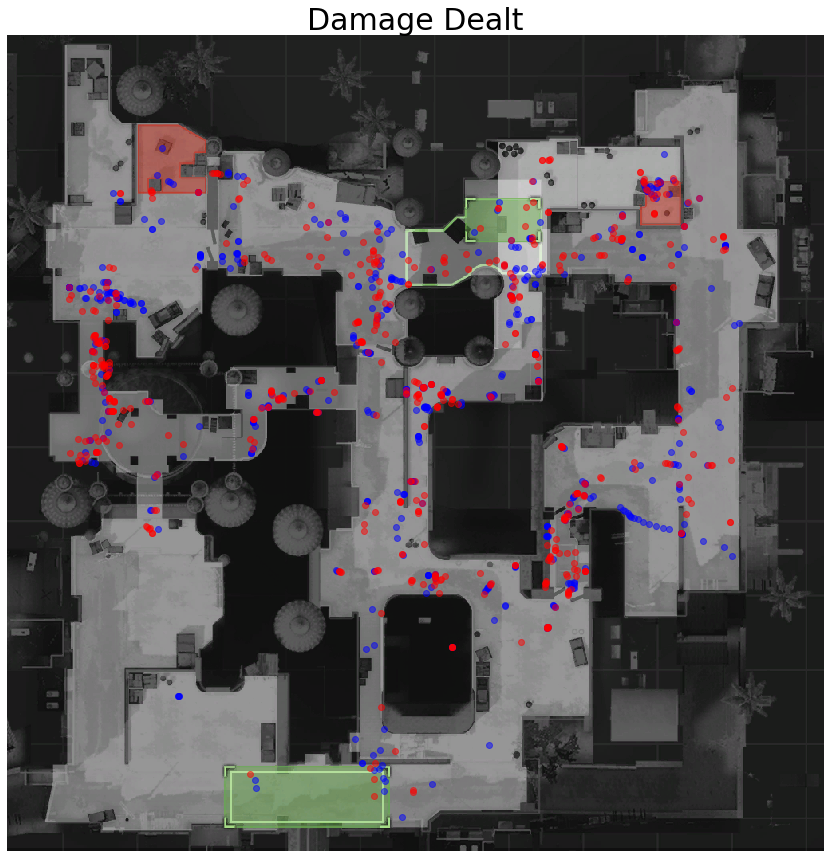

In [ ]:
map_input = "de_dust2"
bg = imread(f'data/maps/{map_input}.png')

#select random game from dust2 and create matching dataframe
match = random.choice(list(df.loc[(df.map == map_input)].groupby('match_no').groups.keys()))
plot_df = df.loc[(df.match_no == match)] 

#find map coordinate data from map dataframe
map_data = mapdf.loc[mapdf.map == map_input]
coords = [map_data.StartX.sum(), map_data.EndX.sum(), map_data.StartY.sum(), map_data.EndY.sum()]

#create matplotplib graph and overlay over background image
plt.figure(figsize=(15, 15))
plt.imshow(bg, aspect = 'equal', interpolation = 'none', extent = coords)
plt.scatter(plot_df['att_pos_x'] + 25, plot_df['att_pos_y'], alpha=.5, c='blue')
plt.scatter(plot_df['vic_pos_x'] + 25, plot_df['vic_pos_y'], alpha=.5, c='red')
plt.title(f'Damage Dealt', fontsize=30)
plt.axis('off')
plt.show()

From this image, we can get an idea of where players are most often congregating and dealing/receiving damage to one another. At the top and bottom centers, we can see where the Terrorist spawn (bottom in green) has a line of sight across the middle of the map and through a doorway next to Counter-Terrorist spawn. This is a common area for enemy engagement at the beggingings of rounds, and that is reflected in the data. We also can see that bomb sitses and choke points between the two teams' spawn have the highest density of player interaction, whereas areas like the bottom left have very little data, as these areas do not often see any fighting.

Next, we can look at a more generalized representation of player movements and interactions in a specific map. In this case, we are looking at damage dealt (represented in red) by Terrorists (represented in blue) in the map *Cache* over the course of hundreds of matches (237 to be exact).

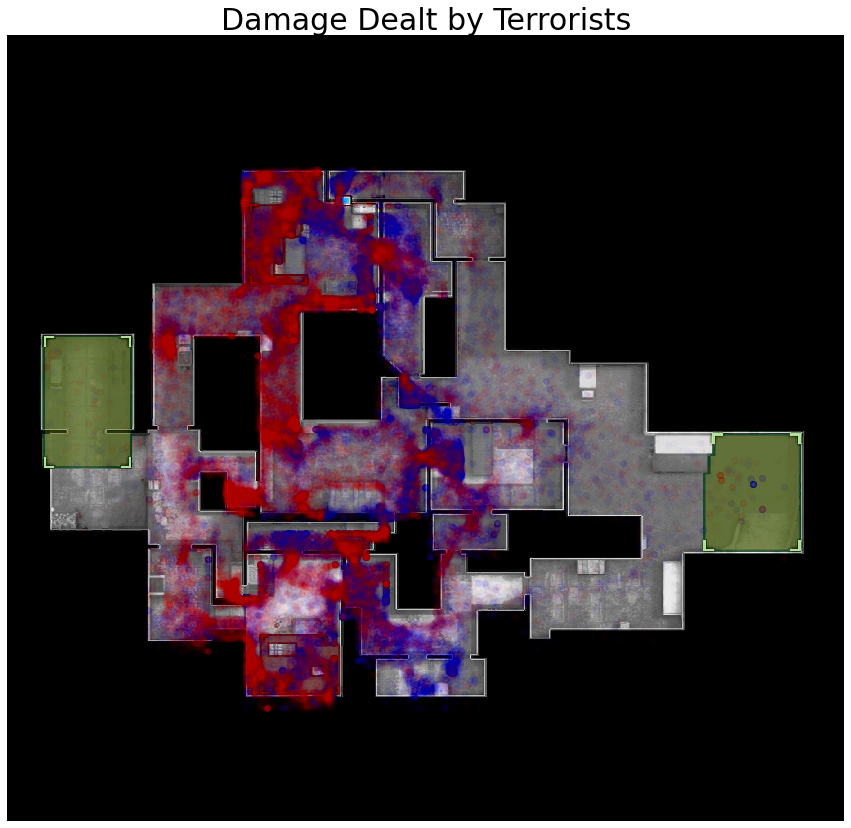

In [ ]:
map_input = "de_cache"
bg = imread(f'data/maps/{map_input}.png')

#select all games from Cache and create matching dataframe
plot_df = df.loc[(df.map == map_input) & (df.att_side == 'Terrorist')] 

#find map coordinate data from map dataframe
map_data = mapdf.loc[mapdf.map == map_input]
coords = [map_data.StartX.sum(), map_data.EndX.sum(), map_data.StartY.sum(), map_data.EndY.sum()]

#create matplotplib graph and overlay over background image
plt.figure(figsize=(15, 15))
plt.imshow(bg, aspect = 'equal', interpolation = 'none', extent = coords)
plt.scatter(plot_df['att_pos_x'] + 25, plot_df['att_pos_y'], alpha=.01, c='blue')
plt.scatter(plot_df['vic_pos_x'] + 25, plot_df['vic_pos_y'], alpha=.01, c='red')
plt.title(f'Damage Dealt by Terrorists', fontsize=30)
plt.axis('off')
plt.show()

From this, we can see clear trends in where the terrorists and counter-terrorists are attacking each other. The distribution of terrorists on the right and counter-terrorists on the left (where they spawn, respectively) is very clear, and commong Counter-Terrorist defensive positions appear as large red masses, as this is where they are being attacked by terrorists.

We can now look again at the exact same data, but this time restricted to only players using the 'AWP', a powerful sniper.

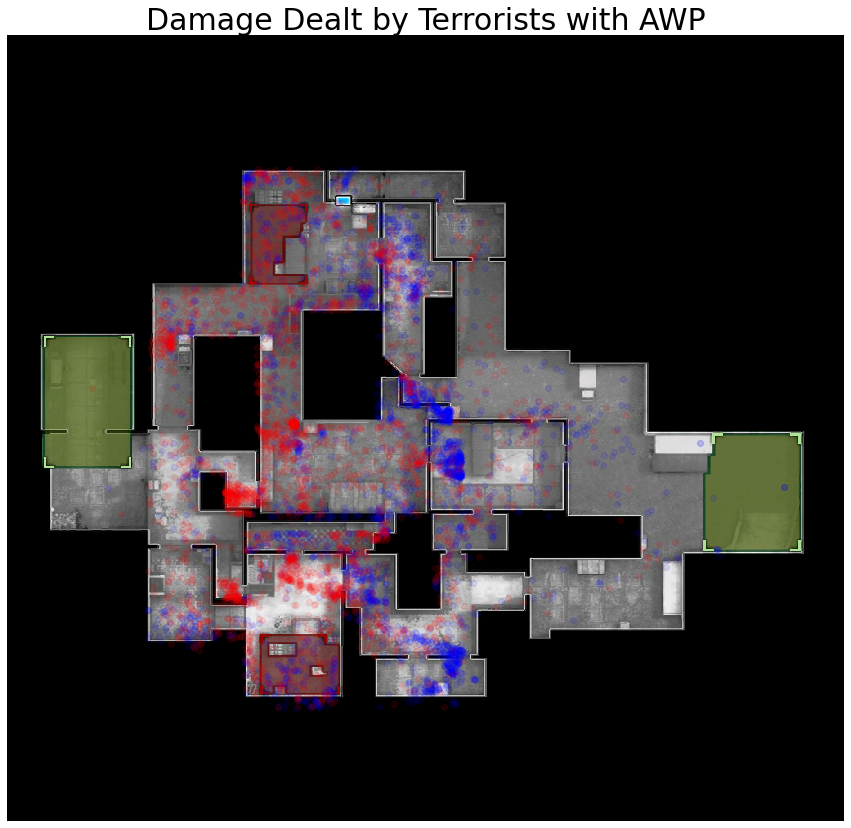

In [ ]:
map_input = "de_cache"
bg = imread(f'data/maps/{map_input}.png')

#select all games from cache with AWP and create matching dataframe
plot_df = df.loc[(df.map == map_input) & (df.att_side == 'Terrorist') & (df.wp == 'AWP')] 

#find map coordinate data from map dataframe
map_data = mapdf.loc[mapdf.map == map_input]
coords = [map_data.StartX.sum(), map_data.EndX.sum(), map_data.StartY.sum(), map_data.EndY.sum()]

#create matplotplib graph and overlay over background image
plt.figure(figsize=(15, 15))
plt.imshow(bg, aspect = 'equal', interpolation = 'none', extent = coords)
plt.scatter(plot_df['att_pos_x'] + 25, plot_df['att_pos_y'], alpha=.1, c='blue')
plt.scatter(plot_df['vic_pos_x'] + 25, plot_df['vic_pos_y'], alpha=.1, c='red')
plt.title(f'Damage Dealt by Terrorists with AWP', fontsize=30)
plt.axis('off')
plt.show()

We can see that the range of engagement is much longer here than in our previous map, with the distance between clusters of players dealing/receiving damage being much greater. Similar yet opposite trends can be seen when selecting for short range weapons like shotguns. 

Next, we can use a similar positional analysis technique to analyze how players use their grenades within a match, specifically how they use smoke grenades. Smoke grenades provide an opaque wall of smoke that Terrorists will use to block Counter-Terrorist sightlines when attacking and Counter-Terrorists will use to prevent their enemies from moving into a bombsite. The thrower of each smoke grenade is represented in **red**, while the landing spot of each smoke grenade is represented in **blue**.

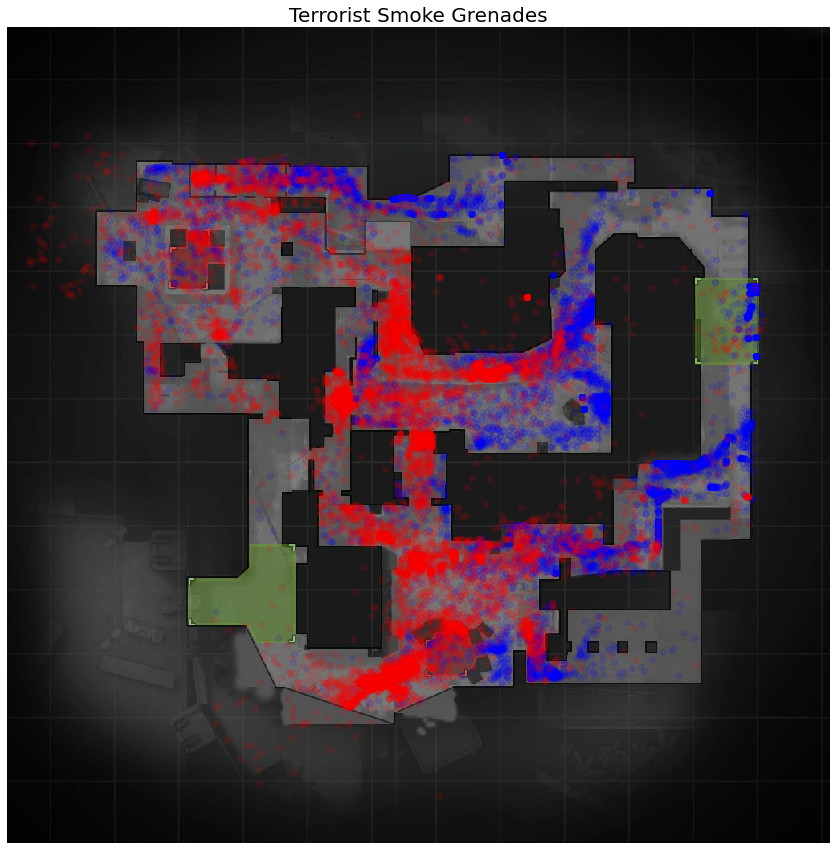

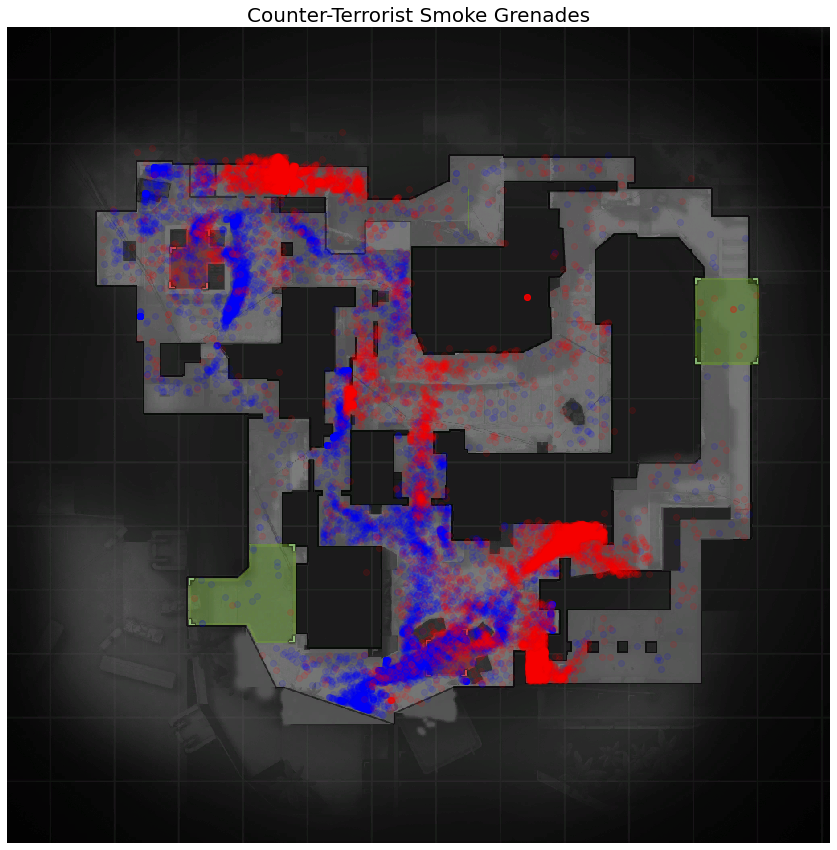

In [ ]:
map_input = "de_mirage"

#create plot dataframe
plot_df = grenadedf.loc[(grenadedf.nade == 'Smoke') & (grenadedf.map == map_input) & (grenadedf.att_side == 'Terrorist')] 
bg = imread(f'data/maps/{map_input}.png')

#fetch map data
map_data = mapdf.loc[mapdf.map == map_input]
coords = [map_data.StartX.sum(), map_data.EndX.sum(), map_data.StartY.sum(), map_data.EndY.sum()]

#create plot and display background
plt.figure(figsize=(15, 15))
plt.imshow(bg, aspect = 'equal', interpolation = 'none', extent = coords)
plt.scatter(plot_df['att_pos_x'] + 25, plot_df['att_pos_y'], alpha=.1, c='blue')
plt.scatter(plot_df['nade_land_x'] + 25, plot_df['nade_land_y'], alpha=.11, c='red')
plt.title(f'Terrorist Smoke Grenades', fontsize=20)
plt.axis('off')
plt.show()

#create plot dataframe
plot_df = grenadedf.loc[(grenadedf.nade == 'Smoke') & (grenadedf.map == map_input) & (grenadedf.att_side == 'CounterTerrorist')] 
bg = imread(f'data/maps/{map_input}.png')

#fetch map data
map_data = mapdf.loc[mapdf.map == map_input]
coords = [map_data.StartX.sum(), map_data.EndX.sum(), map_data.StartY.sum(), map_data.EndY.sum()]

#create plot and display background
plt.figure(figsize=(15, 15))
plt.imshow(bg, aspect = 'equal', interpolation = 'none', extent = coords)
plt.scatter(plot_df['att_pos_x'] + 25, plot_df['att_pos_y'], alpha=.1, c='blue')
plt.scatter(plot_df['nade_land_x'] + 25, plot_df['nade_land_y'], alpha=.11, c='red')
plt.title(f'Counter-Terrorist Smoke Grenades', fontsize=20)
plt.axis('off')
plt.show()

As we can see, the terrorists (right side spawn) have a tendency their grenades from between their spawn A site (bottom center) and cut off the line of sight between their attack position and Counter-Terrorist spawn. A similar trend can be seen at site B (top left), though less well defined.

The Counter Terrorists, on the other hand, tend to throw the majority of their smokes at the choke points where the Terrorists pass through while trying to reach the bomb sites.

While the clusters are noticeable, it is also clear that the smoke grenades do not all land in their exact intended spot. We can select for only matches where the average player rank was above a certain threshold and see how that changes the outcome.

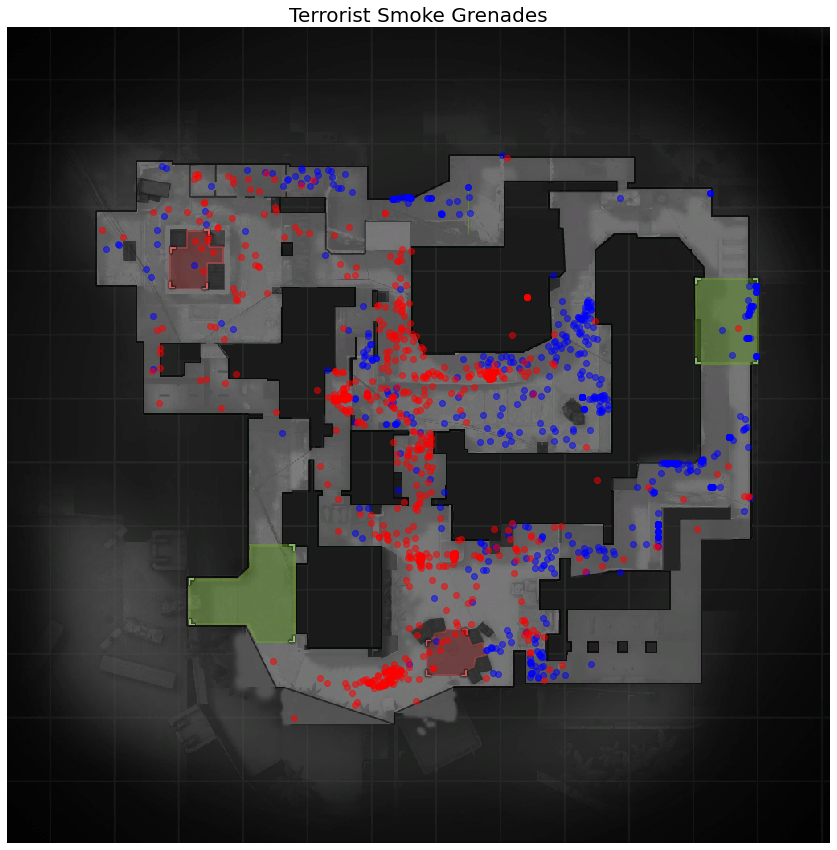

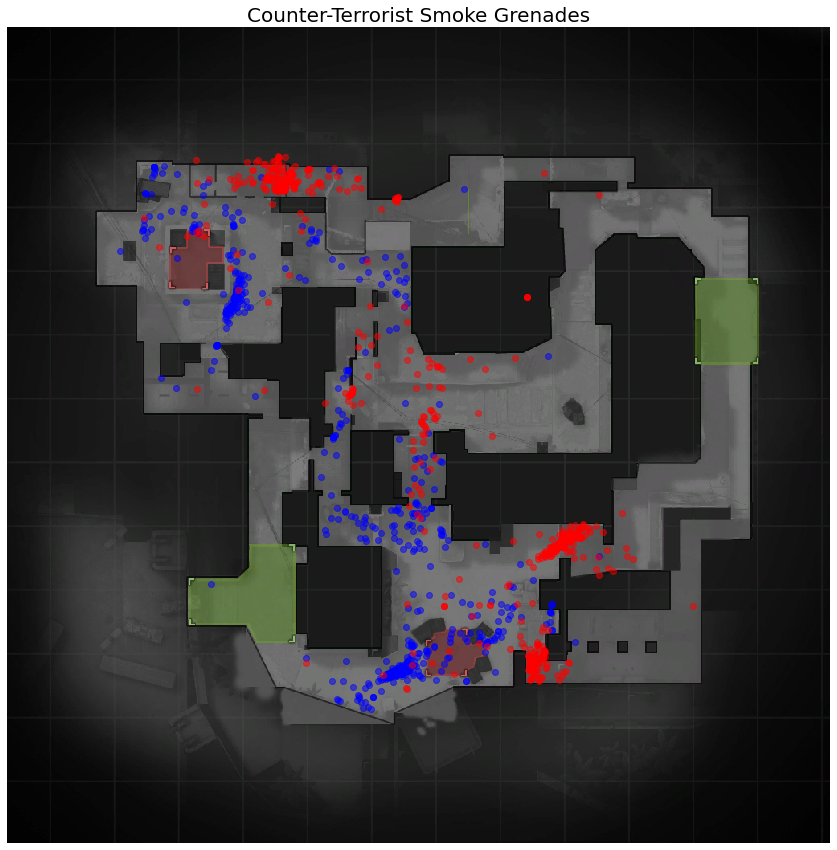

In [ ]:
map_input = "de_mirage"

#create plot dataframe
plot_df = grenadedf.loc[(grenadedf.nade == 'Smoke') & (grenadedf.map == map_input) & (grenadedf.att_side == 'Terrorist') & (grenadedf.avg_match_rank > 15)] 
bg = imread(f'data/maps/{map_input}.png')

#fetch map data
map_data = mapdf.loc[mapdf.map == map_input]
coords = [map_data.StartX.sum(), map_data.EndX.sum(), map_data.StartY.sum(), map_data.EndY.sum()]

#create plot and display background
plt.figure(figsize=(15, 15))
plt.imshow(bg, aspect = 'equal', interpolation = 'none', extent = coords)
plt.scatter(plot_df['att_pos_x'] + 25, plot_df['att_pos_y'], alpha=.5, c='blue')
plt.scatter(plot_df['nade_land_x'] + 25, plot_df['nade_land_y'], alpha=.5, c='red')
plt.title(f'Terrorist Smoke Grenades', fontsize=20)
plt.axis('off')
plt.show()

#create plot dataframe
plot_df = grenadedf.loc[(grenadedf.nade == 'Smoke') & (grenadedf.map == map_input) & (grenadedf.att_side == 'CounterTerrorist') & (grenadedf.avg_match_rank > 15)] 
bg = imread(f'data/maps/{map_input}.png')

#fetch map data
map_data = mapdf.loc[mapdf.map == map_input]
coords = [map_data.StartX.sum(), map_data.EndX.sum(), map_data.StartY.sum(), map_data.EndY.sum()]

#create plot and display background
plt.figure(figsize=(15, 15))
plt.imshow(bg, aspect = 'equal', interpolation = 'none', extent = coords)
plt.scatter(plot_df['att_pos_x'] + 25, plot_df['att_pos_y'], alpha=.5, c='blue')
plt.scatter(plot_df['nade_land_x'] + 25, plot_df['nade_land_y'], alpha=.5, c='red')
plt.title(f'Counter-Terrorist Smoke Grenades', fontsize=20)
plt.axis('off')
plt.show()

Here we can see the same data as before, but with much less variance in the positions. It is clear that these higher-ranked players have more experience and are more consistent in throwing accurate smoke grenades. We can also see that these higher-rank players appear to not use smoke grenades when attacking B very often relative to the general populace. Presenting the data like this can be valuable in finding insight into strategies that you may not be aware of.

##Analyzing the relation of economy to round win-rate

Next, we analyzed how a teams' spending habits predict whether or not they will win a round. Obviously, our hypothesis was that spending more money than the other team would result in increased chances of winning the round. To check this, we needed to group our data into individual rounds and look at whether the team who spent more in that round also won the round. To do this, we used our *'higher_wins'* column that we created earlier. We then calculated the differences in team spending into increments of $1000 and found the winrate of the higher spending teams within these increments. Finally, we used the matplotlib data visualization library, **seaborn**, to plot this in a bar graph. [seaborn documentation](https://seaborn.pydata.org/)

In [ ]:
grouped = df.groupby(['match_no', 'round'])

#group data into individual rounds
econdf = pd.DataFrame()
count = 0
for name, group in grouped:
  econdf = pd.concat([econdf, group.head(1)], ignore_index = True)
  count += 1
  if count > 25000:
    break

#create new dataframe from grouped data for plotting purposes
econdf = econdf[['ct_eq_val', 't_eq_val', 'higher_wins']]
for index, row in econdf.iterrows():
  econdf.at[index, 'diff'] = abs(row['ct_eq_val'] - row['t_eq_val'])

econ = econdf.groupby(['diff'])['higher_wins'].mean().to_frame()
for index, row in econgrouped.iterrows():
  econ.at[index, 'diffc'] = index

#take avg of winning proabibility in increments of $1000
problist = []
for i in range(0, 30000, 1000):
  avg = econ.loc[(econ['diffc'] > i) & (econ['diffc'] <= i + 1000)]
  problist.append(avg['higher_wins'].mean())



Text(0.5, 1.0, 'Probability of team with higher value equipment winning round')

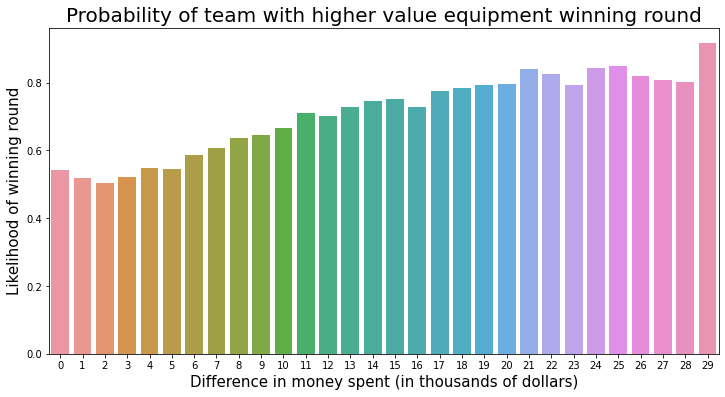

In [ ]:
X = []
Y = []

#create x and y variables from earlier data
for i in range(0, 30):
    X.append(i)

for prob in problist:
    Y.append(prob)

#create plot
plt.figure(figsize=(12,6))
p = sns.barplot(x=X, y = Y, orient='v')
p.set_xlabel("Difference in money spent (in thousands of dollars)", fontsize = 15)
p.set_ylabel("Likelihood of winning round", fontsize = 15)
p.set_title('Probability of team with higher value equipment winning round', fontsize = 20)

As we can see, the likelihood of winning a round clearly correlates with how much more money a team spends than their opponents. While the probability of winning hovers around 50% when the difference is <\$5000, it increases to nearly 100% when the difference in spending approaches \$30,000. This just demonstrates how important the economy in Counter Strike is and how difficult it is to win a round against a full-buying team when you are on an eco or force buy round. While more analysis could be done of the economic impact on round wins, we would find the same trends.

##Weapon Analysis

Next, we wanted to look at the statistics around different weapons' usage. Specifically, we wanted to analyze how effective weapons are at different ranges. For example, we predicted that a sniper would logically have more use at long ranges and a shotgun or SMG would have more use at close ranges.

First, we needed to calculate the average distance that each different weapon was used to kill an enemy. To do this, we would need to calculate when a player was killed by seeing when the sum of their damage reached 100 (Counter Strike has no health regeneration), then calculate their average distance from their killer over the course of receiving damage using the pythagorean theorem ($x^2 + y^2 = z^2$). We chose to use the average distance over the course of the engagement to account for enemies moving during the fight. Often, the engagement would start at a long distance, then the losing player would take cover and be pushed by the attacking player. If we only took the final distance, our data would likely be lower than is an accurate representation.

In [ ]:
groups = df.groupby(['match_no', 'round', 'vic_id'])

netWeaponDistances = {}
netWeaponInstances = {}

netWeaponTypeDistances = {}
netWeaponTypeInstances = {}

#get distance with pythag
def distance(x1,y1,x2,y2):
     return math.sqrt( ((int(x1)-int(x2))**2)+((int(y1)-int(y2))**2) )

#find average distance for multiple hits
def meanDistance(AttackXCords, AttackYCords, VictimXCords, VictimYCords):
    totalDistance = 0.0
    totalHits = 0

    merged_list = tuple(zip(AttackXCords, AttackYCords,VictimXCords,VictimYCords))

    for tup in merged_list:
        x1 = tup[0]
        y1 = tup[1]
        x2 = tup[2]
        y2 = tup[3]

        totalDistance = totalDistance + distance(x1,y1,x2,y2)
        totalHits = totalHits + 1

    return totalDistance/totalHits



for name, group in groups:

    totalDamage = group['hp_dmg'].sum()
    result = True
    weaponUsed = group['wp']

    weaponTypeUsed = group['wp_type']

    numIters = 0

    weaponType = ''
    
    for elt in weaponTypeUsed:
        if numIters == 0:
            weaponType = elt
        elif weaponType != elt:
            result = False
            break
        
        numIters = 1

    numIters = 0
    weapon = ''
    
    for elt in weaponUsed:
        if numIters == 0:
            weapon = elt
        elif weapon != elt:
            result = False
            break
        
        numIters = 1

    if weapon == 'Unknown' or weaponType == 'Equipment' or weaponType == 'Grenade':
        continue

    if (result):
        if totalDamage == 100:
            AX = group['att_pos_x']
            AY = group['att_pos_y']

            VX = group['vic_pos_x']
            VY = group['vic_pos_y']
          
            try:
                netWeaponDistances[weapon] = netWeaponDistances[weapon] + meanDistance(AX,AY,VX,VY)
            except KeyError:
                netWeaponDistances[weapon] = meanDistance(AX,AY,VX,VY)

            try:
                netWeaponInstances[weapon] = netWeaponInstances[weapon] + 1
            except KeyError:
                netWeaponInstances[weapon] = 1

            try:
                netWeaponTypeDistances[weaponType] = netWeaponTypeDistances[weaponType] + meanDistance(AX,AY,VX,VY)
            except KeyError:
                netWeaponTypeDistances[weaponType] = meanDistance(AX,AY,VX,VY)

            try:
                netWeaponTypeInstances[weaponType] = netWeaponTypeInstances[weaponType] + 1
            except KeyError:
                netWeaponTypeInstances[weaponType] = 1
        
    
    

finalWeaponDistances = {}

for key in netWeaponDistances:
    finalWeaponDistances[key] = netWeaponDistances[key] / netWeaponInstances[key]

finalWeaponTypeDistances = {}

for key in netWeaponTypeDistances:
    finalWeaponTypeDistances[key] = netWeaponTypeDistances[key] / netWeaponTypeInstances[key]

sortedWeaponDistances = {k: v for k, v in sorted(finalWeaponDistances.items(), key=lambda item: item[1])}

sortedWeaponTypeDistances = {k: v for k, v in sorted(finalWeaponTypeDistances.items(), key=lambda item: item[1])}

#print(sortedWeaponDistances)

After calculating these distances, we wanted to plot them on a bar plot for each weapon. We did this once again using seaborn. 

Text(0, 0.5, 'Distance (in Source engine units)')

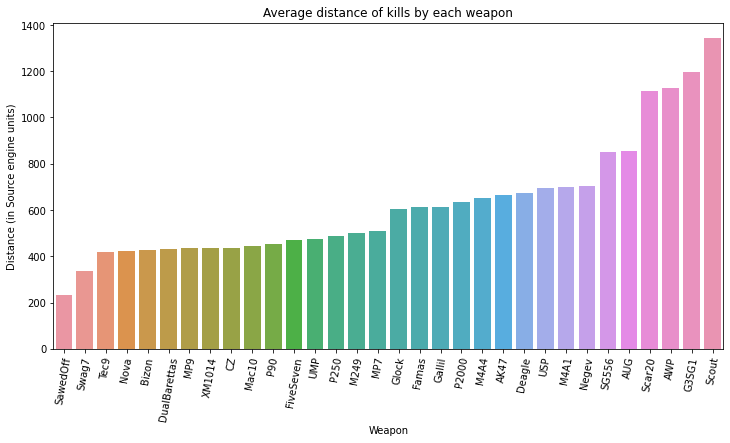

In [ ]:
X = []
Y = []

for weapon in sortedWeaponDistances.keys():
    X.append(str(weapon))

for dist in sortedWeaponDistances.values():
    Y.append(float(dist))

plt.figure(figsize=(12,6))
plt.xticks(rotation = 80)
p = sns.barplot(x=X, y = Y, orient='v')
p.set_title('Average distance of kills by each weapon')
p.set_xlabel('Weapon')
p.set_ylabel('Distance (in Source engine units)')

As would be expected, different weapons have different average ranges of kills. Short range weapons like the Sawed-off Shotgun and Tec-9 (pistol) have extremely close effective ranges and snipers like the AWP, G3SG1, and Scout have the longest effective ranges.

Now is a good time to explain how distance works in CS:GO's Source Engine. 16 units of distance in Source Engine is equivalent to 1 foot in real world terms. By this, a sawed off has a real world equivalent effective range of ~14', whereas a scout has a range of ~85'. [Source Engine dimensions](https://developer.valvesoftware.com/wiki/Dimensions)

Next, we calculated the average weapon ranges among the five different weapon classes. Heavy(shotguns/LMGs), SMGs, Pistols, Rifles, and Snipers

Text(0.5, 1.0, 'Avergae distance of kills by weapon class')

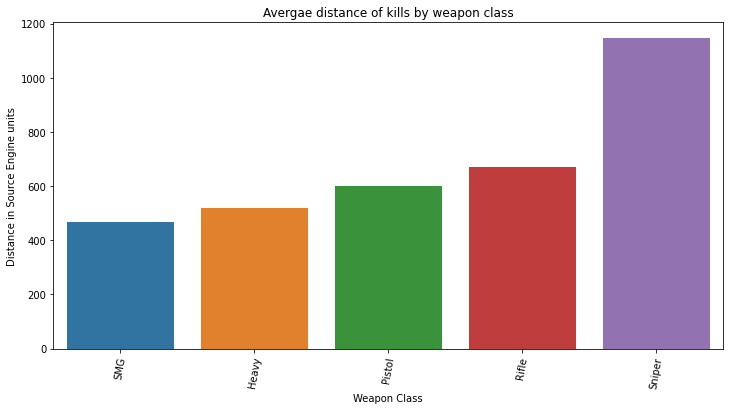

In [ ]:
X = []
Y = []

for weaponType in sortedWeaponTypeDistances.keys():
    X.append(str(weaponType))

for dist in sortedWeaponTypeDistances.values():
    Y.append(float(dist))

plt.figure(figsize=(12,6))
plt.xticks(rotation = 80)
p = sns.barplot(x=X, y = Y, orient='v')
p.set_ylabel('Distance in Source Engine units')
p.set_xlabel('Weapon Class')
p.set_title('Avergae distance of kills by weapon class')

This data is once again consistent with what one would expect. The heavy weapons category is slightly misleading, as it contains both shotguns which have a close effective range and LMGs which have a far effective range. 

Next, we analyzed different weapon matchups. Our hypothesis was that a matchup like a pistol vs sniper would have interesting results, where the sniper wins in long range engagements and the pistol wins in close range engagements.

In [ ]:
def roundup(x):
    return int(math.ceil(x / 600.0)) * 600
    

roundGroups = df.groupby(['match_no', 'round'])

weaponDistanceHealth = {} #  weapon -> list of (distance, health) tuples 





# map each attacker for each round with their weapon that round, then search the dict for their ID and if they are there' retrieve their gun
# go through each value of attacker, see if they killed the other person (2 people can show up as attackers, but just one of them will win)

weaponKills = {} # 'tuple' (<weapon of attacker used to kill>, <weapon of victim who died>) -> (number of times this happened, TOTAL DISTANCE) , we will eventually compare the inverse to find a win average and calculate mean distance of a win

weaponTypeKills = {} # 'tuple' (<weapon type of attacker used to kill>, <weapon of victim who died>) -> (number of times this happened, TOTAL DISTANCE) , we will eventually compare the inverse to find a win average and calculate mean distance of a win


rowCount = 0

#mappedEncounters = {}

# we need a mapping of attacker -> victims they attacked and also a mapping victims -> who they got attacked by


for name, round in roundGroups:
    roundDF = pd.DataFrame(round)

    # for each round, make a dict mapping player ID to their weapon that round
    playerWeapons = {}  # playerID -> weapon used this round

    # if the encounter resulted in 100 damage, then the enemy was killed, log it as a kill from one weapon vs another and also the distance the players were
    #weaponKills = {}  # weapon used to kill -> weapon of victim

    # have to keep track of each victim's health throughout the whole round. If victim health reaches <=0, then map the attacker's weapon to the victim's weapon if it exists.
    # If the victim doesn't yet exist in the mapping, then subtract the damage done from 100
    playerHealth = {}  # playerID -> health (0-100)


    playerWeaponClasses = {}



    for index, row in roundDF.iterrows():
        rowCount = rowCount + 1

        attacker = row['att_id']
        victim = row['vic_id']

        attackWeapon = row['wp']
        damage = row['hp_dmg']

        weaponClass = row['wp_type']


        AX = row['att_pos_x']
        AY = row['att_pos_y']

        VX = row['vic_pos_x']
        VY = row['vic_pos_y']
        
        # removes non-weapons from consideration
        if attackWeapon == 'Unknown' or weaponClass == 'Equipment' or weaponClass == 'Grenade':
            continue
        

        # map each player's weapon from the round
        playerWeapons[attacker] = attackWeapon
        playerWeaponClasses[attacker] = weaponClass


        # map each player's health
        try:
            playerHealth[victim] = playerHealth[victim] - damage
        except KeyError:
            playerHealth[victim] = 100 - damage

        if attacker not in playerHealth:
            playerHealth[attacker] = 100
       
        
        
            


        # check if victim is dead
        if playerHealth[victim] <= 0:
            # check if victim's weapon is logged
            try:
                victimWeapon = playerWeapons[victim]
                victimWeaponClass = playerWeaponClasses[victim]


                try:
                    _distanceMAP = weaponTypeKills[(weaponClass, victimWeaponClass)] 
                    
                    dist_ = roundup(distance(AX, AY, VX, VY))

                    try:
                        currTup = _distanceMAP[dist_]
                        (_wins) = currTup
                        _distanceMAP[dist_] = (_wins + 1)
                        weaponTypeKills[(weaponClass, victimWeaponClass)] = _distanceMAP
                        
                    except KeyError:
                        _distanceMAP[dist_] = (1)
                        weaponTypeKills[(weaponClass, weaponClass)] = _distanceMAP
                    
                except KeyError:
                    weaponTypeKills[(weaponClass, victimWeaponClass)] = {roundup(distance(AX, AY, VX, VY)) : (1)}



                try:


                    # WEAPON CLASS TRACKING
                    try:
                        list_ = weaponDistanceHealth[weaponClass]
                        list_.append((distance(AX, AY, VX, VY),playerHealth[attacker]))
            
                        weaponDistanceHealth[weaponClass] = list_
                    except (KeyError, AttributeError):
                        list2_ = []
                        list2_.append((distance(AX, AY, VX, VY),playerHealth[attacker]))
                        weaponDistanceHealth[weaponClass] = list2_



                    
                    try:
                        list_ = weaponDistanceHealth[victimWeaponClass]
                        list_.append((distance(AX, AY, VX, VY),playerHealth[victim]))
            
                        weaponDistanceHealth[victimWeaponClass] = list_
                    except (KeyError, AttributeError):
                        list2_ = []
                        list2_.append((distance(AX, AY, VX, VY),playerHealth[victim]))
                        weaponDistanceHealth[victimWeaponClass] = list2_

                    
                    ###################################

                    # EXACT WEAPON TRACKING
                    (occurences, totalDistance) = weaponKills[(attackWeapon, victimWeapon)]

                    weaponKills[(attackWeapon, victimWeapon)] = (occurences + 1, totalDistance + distance(AX, AY, VX, VY))
                except KeyError:
                    weaponKills[(attackWeapon, victimWeapon)] = (1, distance(AX, AY, VX, VY))
                    
                    ###################################



            except KeyError:
                pass
                



def f(tup):
    (oc, dist) = tup
    return dist/oc

# Before: weaponKills = 'tuple' (<weapon of attacker used to kill>, <weapon of victim who died>) -> (number of times this happened, TOTAL DISTANCE) 
# After: newDict = (attack weapon, victim weapon) -> mean distance    this is of kills
newDict = {k: f(v) for k, v in weaponKills.items()}


doneMatchups = {}

for item in newDict.items():
    (key_, distance_) = item
    (weapon1, weapon2) = key_

    if key_ in doneMatchups or (weapon2, weapon1) in doneMatchups:
        continue 
    else:
        doneMatchups[key_] = 1


    try:
        weapon2WinDistance = newDict[(weapon2, weapon1)]
    except KeyError:
        weapon2WinDistance = -1





matchups = {}



There are hundreds of different weapon matchups in Counter Strike, so we can't possibly show them all here, but we decided to include a few certain interesting matchups:

Matchup between AWP(Sniper) and Tec9(Pistol):

AWP wins at 914.0047596174438

Tec9 wins at 366.67515708765154

------------------------------------------------------

Matchup between SawedOff(Shotgun) and USP (Pistol):

SawedOff wins at 281.49619076514665

USP wins at 643.471337353963

------------------------------------------------------

Matchup between AK47(Rifle) and M4A4(Rifle)

AK47 wins at 654.5547327705935

M4A4 wins at 665.138594321631

------------------------------------------------------

The full list of weapon matchups can be found [here](https://mattjdurkin.github.io/matchups.txt).

While the individual matchups are interesting, they are not extremely clear for the purpose of showing trends. We thought it would be more clear to show matchups by weapon types to try and find a generalization for which categories of weapon are effective against others at certain ranges. To demonstrate this, we will plot the different categories against one another, showing the probability of one category defeating the other at different ranges of engagements.

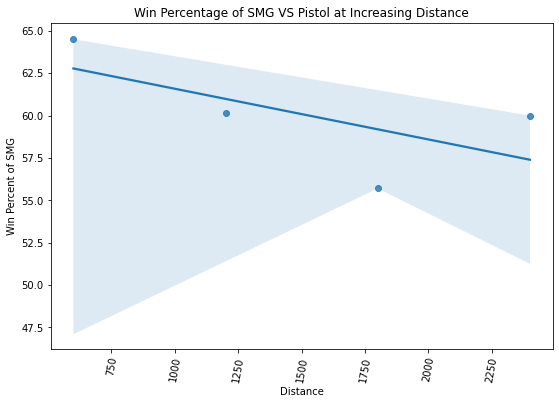

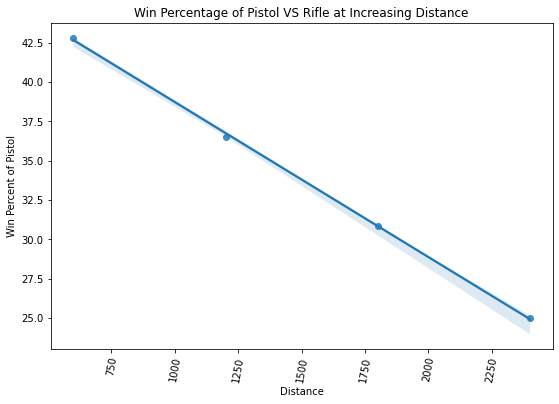

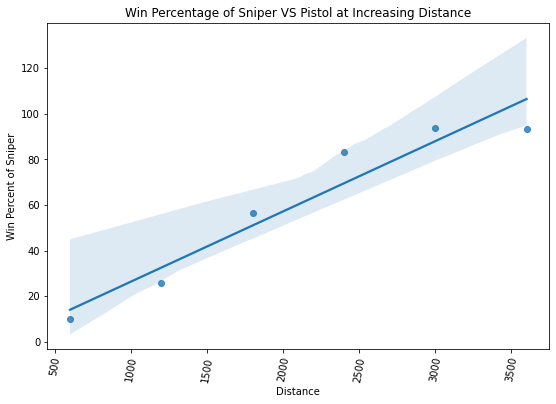

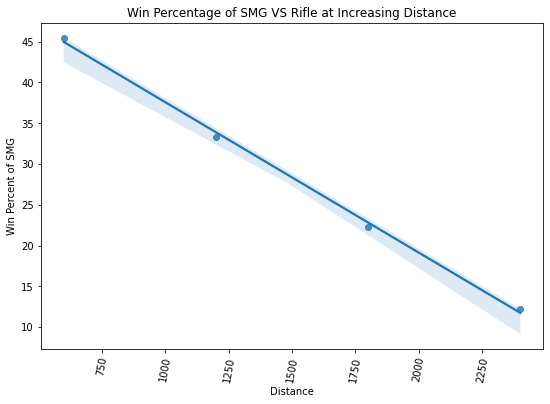

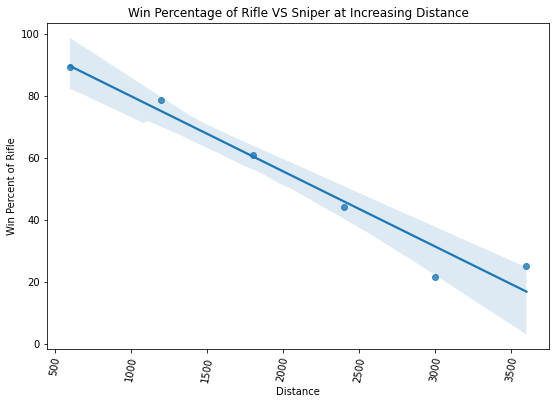

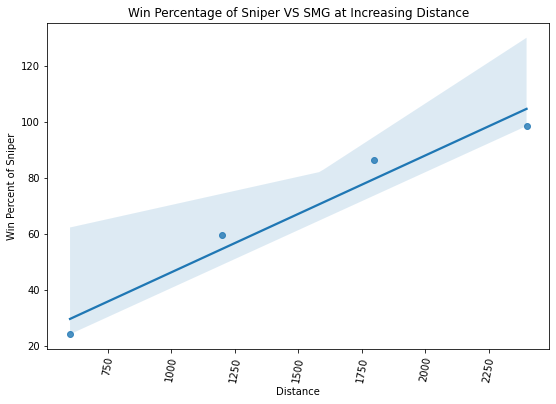

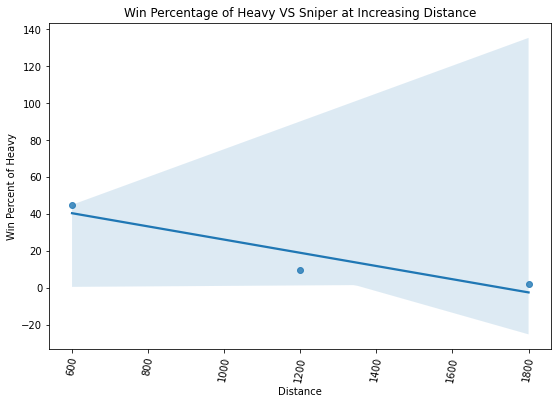

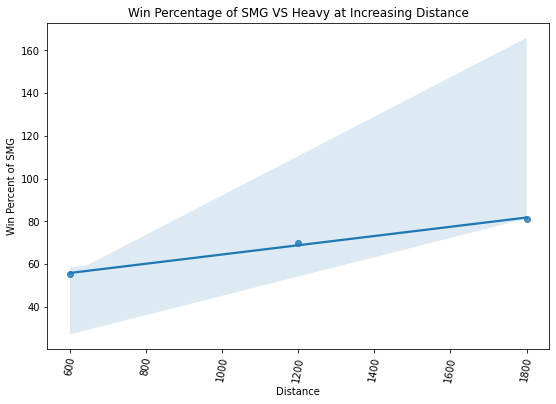

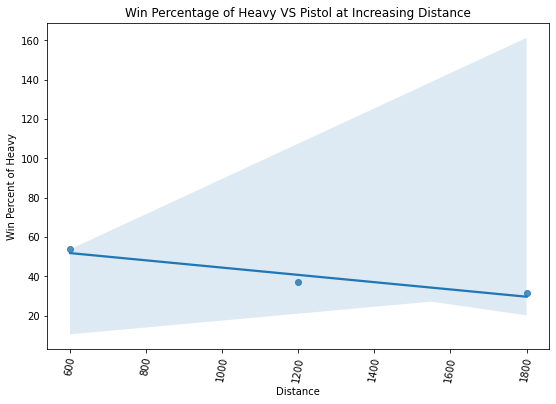

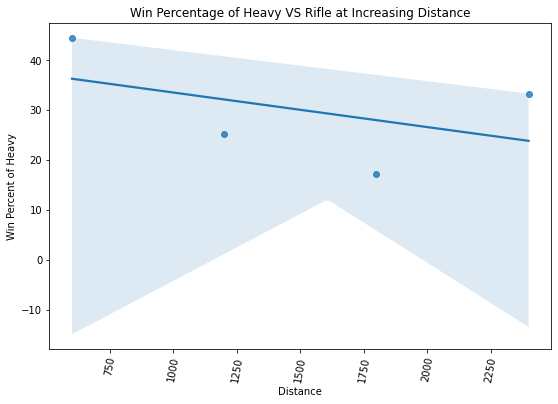

In [ ]:

for elt in weaponTypeKills.items():
    (weaponPair, distWinDict) = elt

    (w1,w2) = weaponPair

    if w1 == w2:
        continue

    if (w2, w1) in matchups:
        continue

    matchups[(w1,w2)] = 1

    X = []
    Y = []

    
    for elt2 in distWinDict.items():
        (dist_2, wins_2) = elt2

        otherDict = weaponTypeKills[(w2,w1)]
        try:
            wins_3 = otherDict[dist_2]
        except KeyError:
            continue


        X.append(dist_2)
        Y.append(float(wins_2)/float(wins_2 + wins_3) * 100.0)
    

    TITLE = "Win Percentage of " + str(w1) + " VS " + str(w2) + ' at Increasing Distance'
    plt.figure(figsize=(9,6))
    plt.xticks(rotation = 80)
    sns.regplot(X,Y).set(title= TITLE, xlabel="Distance", ylabel = "Win Percent of " + str(w1))

These graphs show very clear relations between which weapon category matchups and distance. Nearly every matchup has relatively linear patterns in regards to how the matchup changes at increasing distances. For Sniper vs Pistol, for example, we can see that the chances of a player armed with a sniper beating a player armed with a pistol go from ~20% at close ranges to nearly 100% at the longest ranges. With Rifles vs Snipers, we see the rifle clearly winning close range fights and gradually losing effectiveness until the Sniper is clearly the better option at extreme long ranges. This method of visualization is great for seeing the trends in how these weapon matchups are affected by varying ranges and can be interesting in the context of our previous data, such as the mapping of AWP users on Cache. We can also see that in the case of something like Pistol vs Rifle, the pistol user never has a greater than 50% chance of defeating the rifle user regardless of engagement distance. As pistols are significantly less expensive than rifles, this can help to explain our earlier data indicating that teams who spend more on their equipment have significantly better odds of winning the round. A team that spends \$15k on rifles against a team who only spends \$2k on pistols has very good odds.

We then wanted to plot the frequency of weapons killing at different distances. To do so, we simply counted the amount of weapon kills within different intervals by weapon class.

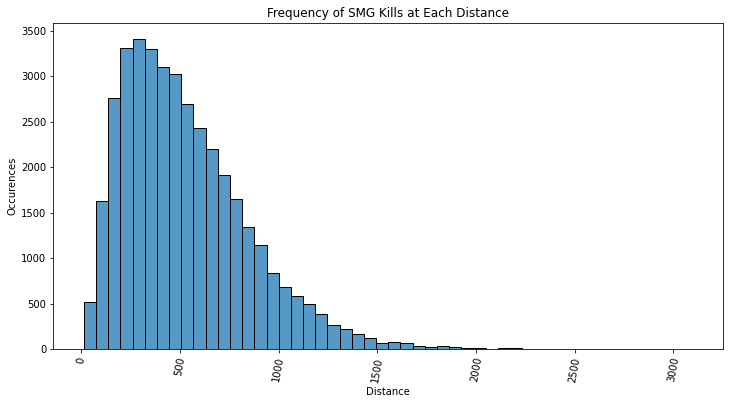

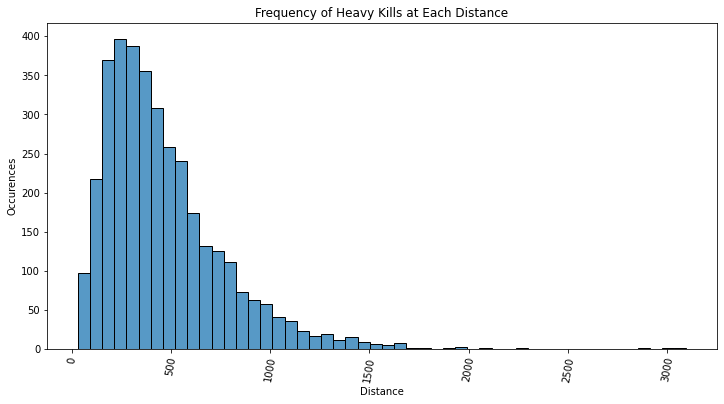

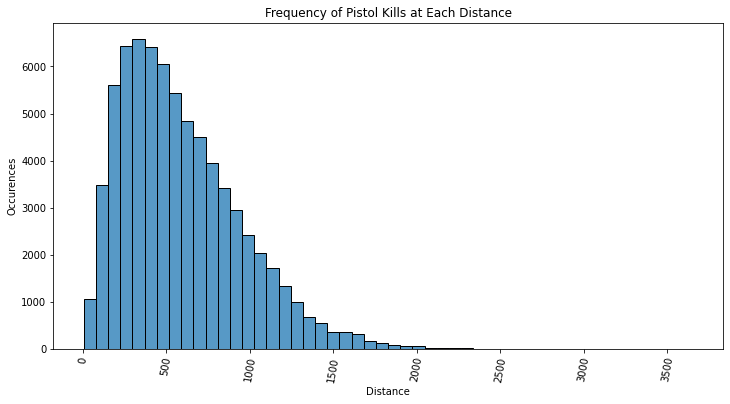

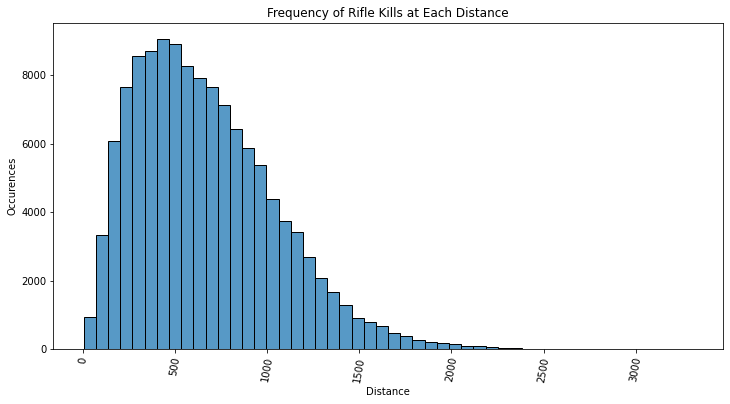

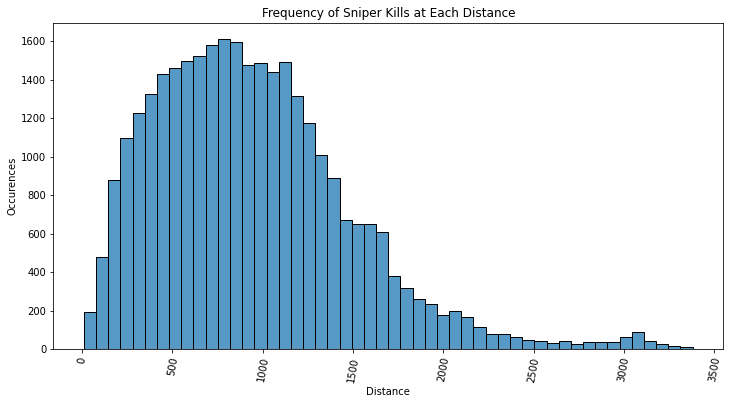

In [ ]:
weaponList = ['SMG', 'Heavy', 'Pistol', 'Rifle', 'Sniper']

endList = []

# weapon -> list of (distance, health) tuples 
for weapon in weaponList:
    

    potentialDists = []

    X = []

    distHealth = {}

      
    for tup in weaponDistanceHealth[weapon]:
        (distance__, health__) = tup

        if health__ >= 0:
            X.append(distance__)
        


    
    TITLE = "Frequency of " + str(weapon) + " Kills at Each Distance"


    plt.figure(figsize=(12,6))
    plt.xticks(rotation = 80)
    sns.histplot(X, bins=50).set(title= TITLE, xlabel="Distance", ylabel = "Occurences")

    endList.append(X)





From these results, we see a few things. All weapons have a large number of kills at very close distances, which can be explained by the general gameplay flow of Counter Strike forcing players into close contact regardless of their weapon choice. We then see that certain weapon classes such as pistols and SMGs have much higher frequency of use in close range engagements than mid range, whereas weapon classes like rifles tend to favor midrange. Finally, we can see a noticeable spike in long range kills by snipers.

# Machine Learning and Regression Modeling

We found that this data could be more easily interpretable if represented in a different type of plot, so we decided to reformat it into a regression plot. Rather than plotting the number of occurrences, we decided to plot the average remaining health of players who attempt to use these weapon types at various ranges. Obviously, a higher remaining health of the attacker means that the weapon was more effective and allowed them to kill their attacker before being killed themselves. A remaining health value of zero indicates that they died in the engagement at that range.

For fitted linear regression: 
Accuracy on training Data: 0.888
Accuracy on test Data: 0.917

The root-mean-square deviation of the training set is: 3.9619833529682196
The root-mean-square deviation of the testing set is: 3.0710325832464105
For fitted linear regression: 
Accuracy on training Data: 0.888
Accuracy on test Data: 0.893

The root-mean-square deviation of the training set is: 5.003074825279671
The root-mean-square deviation of the testing set is: 4.179006128064249
For fitted linear regression: 
Accuracy on training Data: 0.783
Accuracy on test Data: 0.518

The root-mean-square deviation of the training set is: 3.0840603623909164
The root-mean-square deviation of the testing set is: 2.111298928664904
For fitted linear regression: 
Accuracy on training Data: 0.619
Accuracy on test Data: 0.655

The root-mean-square deviation of the training set is: 2.237135434454431
The root-mean-square deviation of the testing set is: 1.8984232380457249
For fitted linear regression: 
Accuracy 

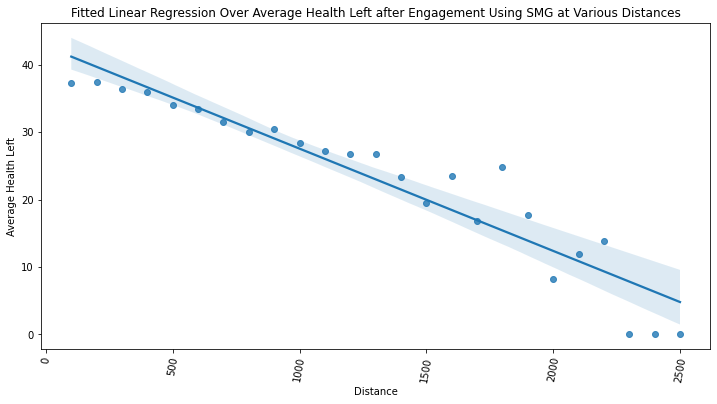

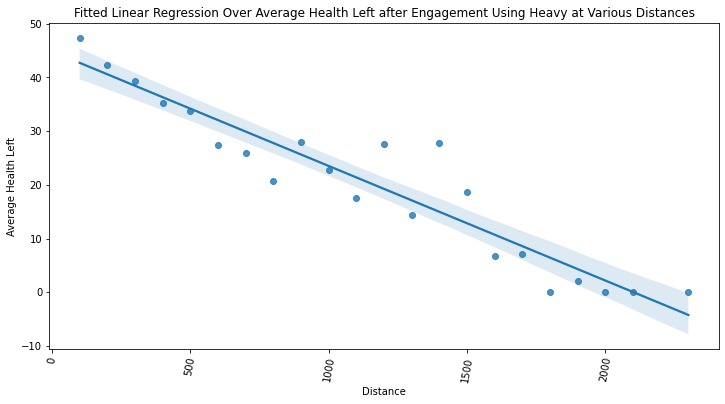

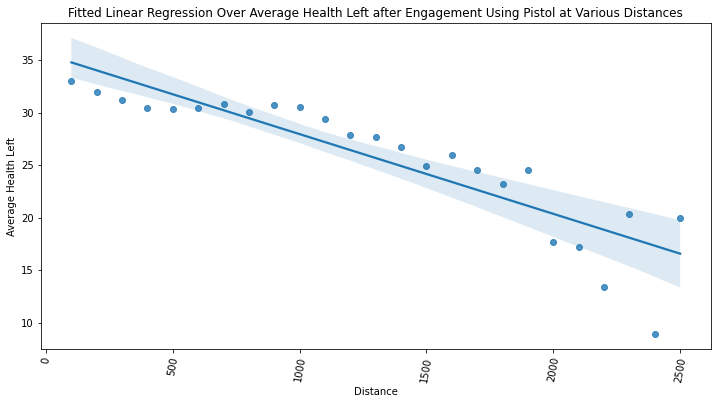

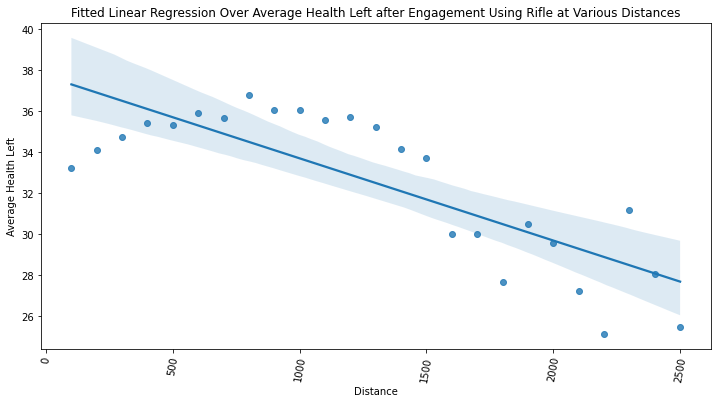

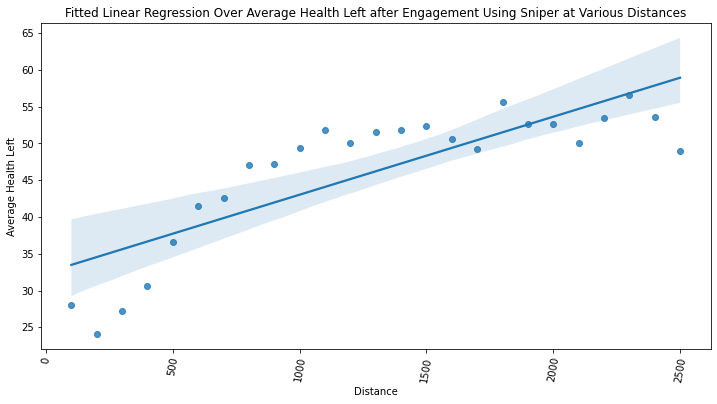

In [ ]:
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100


weaponList = ['SMG', 'Heavy', 'Pistol', 'Rifle', 'Sniper']

for weapon in weaponList:
    X = []
    Y = []

    distHealth = {}


    for tup in weaponDistanceHealth[weapon]:
        (distance__, health__) = tup
        
        if health__ < 0:
            continue


        roundDist = roundup(distance__)
        
        if distance__ >= 2500:
            continue

        try:
            list_ = distHealth[roundDist]
            list_.append(health__)
                
            distHealth[roundDist] = list_
        except (KeyError, AttributeError):
                list2_ = []
                list2_.append(health__)
                distHealth[roundDist] = list2_
        

    for tup in distHealth.items():
        (DISTANCE, HEALTH) = tup
        X.append(DISTANCE)
        Y.append(mean(HEALTH))


    TITLE = "Fitted Linear Regression Over Average Health Left after Engagement Using " + str(weapon) + " at Various Distances"
    plt.figure(figsize=(12,6))
    plt.xticks(rotation = 80)
    sns.regplot(X,Y,order=1).set(title= TITLE, xlabel="Distance", ylabel = "Average Health Left")


    
    

    X = np.array(X)
    Y = np.array(Y)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12)

    y_train = y_train.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)

    X_test = X_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # instantiate the model
    lr = LinearRegression()
    # fit the model 
    lr.fit(X_train, y_train)

    #predicting the target value from the model for the samples
    y_test_lr = lr.predict(X_test)
    y_train_lr = lr.predict(X_train)

    #computing the accuracy of the model performance
    acc_train_lr = lr.score(X_train, y_train)
    acc_test_lr = lr.score(X_test, y_test)

    #computing root mean squared error (RMSE)
    rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_lr))
    rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_lr))

    print("For fitted linear regression: ")
    print("Accuracy on training Data: {:.3f}".format(acc_train_lr))
    print("Accuracy on test Data: {:.3f}".format(acc_test_lr))
    print('\nThe root-mean-square deviation of the training set is:', rmse_train_lr)
    print('The root-mean-square deviation of the testing set is:', rmse_test_lr)







    










    

From this, we can more clearly see trends in the effectiveness of different weapon classes. We can see weapon classes like Heavy and Pistol having steep dropoffs past certain ranges, while weapon classes like Sniper only increase in use with range. In the example of the SMG's plot, we see that past 2000 units of range (~125'), the average remaining health approaches zero, indicating that these players usually died when trying to use SMGs at that range. For snipers, we see the opposite effect, which is consistent with earlier findings. We can also see the results of the linear regression analysis, with the accuracy levels indicating that this fitted linear regression is a decent, but not perfect fit. This can be explained by the variance introduced by the human element that this data comes from. While an SMG might be generally less effective than a sniper at a certain range, this data can be skewed by human error.

Next, we will display the residuals from this linear regression.

0.6896410357208638

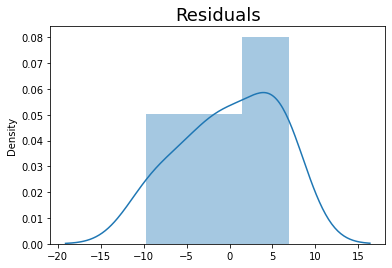

In [ ]:
y_hat = lr.predict(X_train)
sns.distplot(y_train - y_hat)
plt.title("Residuals", size=18)
lr.score(X_train,y_train)

Next, we will take a polynomial regression model on the data from earlier which showed win percentage of each weapon matchup based on distance.

For fitted polynomial regression: 
Accuracy on training Data: 0.930
Accuracy on test Data: 0.960

The root-mean-square deviation of the training set is: 3.1258519504514046
The root-mean-square deviation of the testing set is: 2.143245804361778


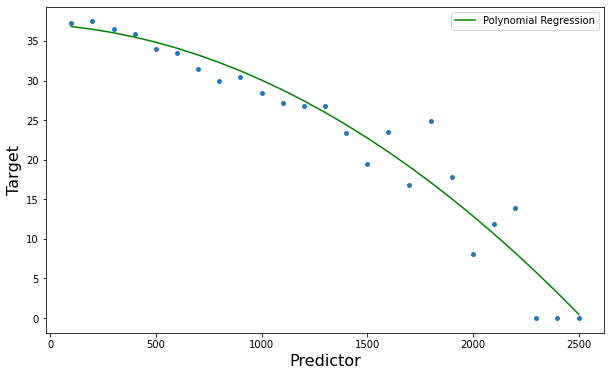

For fitted polynomial regression: 
Accuracy on training Data: 0.893
Accuracy on test Data: 0.872

The root-mean-square deviation of the training set is: 4.907177662037085
The root-mean-square deviation of the testing set is: 4.5644636627843855


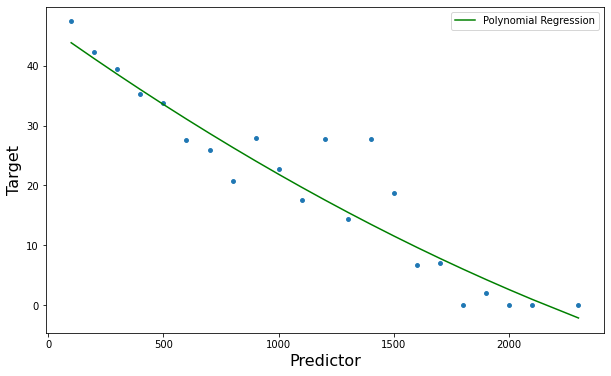

For fitted polynomial regression: 
Accuracy on training Data: 0.821
Accuracy on test Data: 0.921

The root-mean-square deviation of the training set is: 2.797781793869154
The root-mean-square deviation of the testing set is: 0.8523511689519864


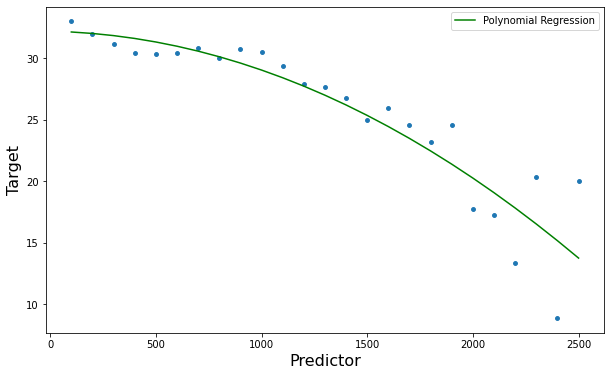

For fitted polynomial regression: 
Accuracy on training Data: 0.787
Accuracy on test Data: 0.752

The root-mean-square deviation of the training set is: 1.6740343557103623
The root-mean-square deviation of the testing set is: 1.6093319497312255


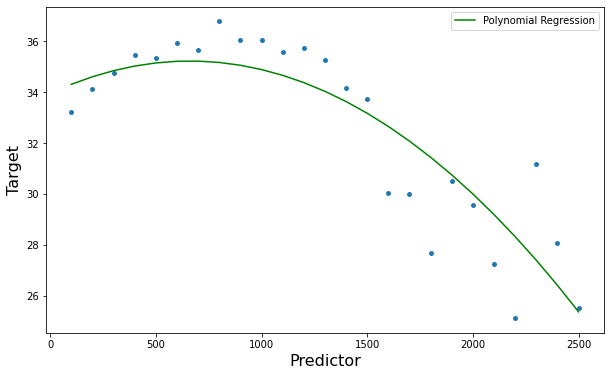

For fitted polynomial regression: 
Accuracy on training Data: 0.922
Accuracy on test Data: 0.924

The root-mean-square deviation of the training set is: 2.7263923230219262
The root-mean-square deviation of the testing set is: 2.1627382821030623


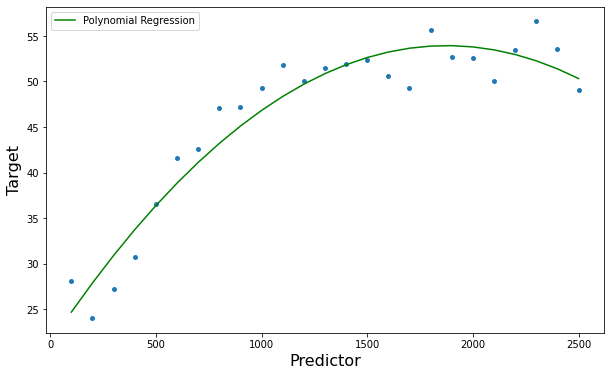

In [ ]:
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100


weaponList = ['SMG', 'Heavy', 'Pistol', 'Rifle', 'Sniper']

# weapon -> list of (distance, health) tuples 
for weapon in weaponList:
    X = []
    Y = []

    distHealth = {}

    #distHealth['<= 300']

    for tup in weaponDistanceHealth[weapon]:
        (distance__, health__) = tup
        
        if health__ < 0:
            continue


        roundDist = roundup(distance__)
        
        if distance__ >= 2500:
            continue

        try:
            list_ = distHealth[roundDist]
            list_.append(health__)
                
            distHealth[roundDist] = list_
        except (KeyError, AttributeError):
                list2_ = []
                list2_.append(health__)
                distHealth[roundDist] = list2_
        

    for tup in distHealth.items():
        (DISTANCE, HEALTH) = tup
        X.append(DISTANCE)
        Y.append(mean(HEALTH))


  

    X = np.array(X)
    Y = np.array(Y)


    # Importing Linear Regression
    from sklearn.linear_model import LinearRegression

    
    # importing libraries for polynomial transform
    from sklearn.preprocessing import PolynomialFeatures
    # for creating pipeline
    from sklearn.pipeline import Pipeline
    # creating pipeline and fitting it on data
    





    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 12)

    y_train = y_train.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)

    X_test = X_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # instantiate the model
    Input=[('polynomial',PolynomialFeatures(degree=2)),('modal',LinearRegression())]
    pipe=Pipeline(Input)
    
    # fit the model 

    pipe.fit(X_train.reshape(-1,1),y_train.reshape(-1,1))    





    #predicting the target value from the model for the samples
    y_test_poly=pipe.predict(X_test)
    y_train_poly=pipe.predict(X_train)


    #computing the accuracy of the model performance
    acc_train_poly = pipe.score(X_train, y_train)
    acc_test_poly = pipe.score(X_test, y_test)

    #computing root mean squared error (RMSE)
    rmse_train_poly = np.sqrt(mean_squared_error(y_train, y_train_poly))
    rmse_test_poly = np.sqrt(mean_squared_error(y_test, y_test_poly))

    print("For fitted polynomial regression: ")
    print("Accuracy on training Data: {:.3f}".format(acc_train_poly))
    print("Accuracy on test Data: {:.3f}".format(acc_test_poly))
    print('\nThe root-mean-square deviation of the training set is:', rmse_train_poly)
    print('The root-mean-square deviation of the testing set is:', rmse_test_poly)







    poly_pred=pipe.predict(X.reshape(-1,1))
    #sorting predicted values with respect to predictor
    sorted_zip = sorted(zip(X,poly_pred))
    x_poly, poly_pred = zip(*sorted_zip)
    #plotting predictions
    plt.figure(figsize=(10,6))
    plt.scatter(X,Y,s=15)
    #plt.plot(X,y_pred,color='r',label='Linear Regression')
    plt.plot(x_poly,poly_pred,color='g',label='Polynomial Regression')
    plt.xlabel('Predictor',fontsize=16)
    plt.ylabel('Target',fontsize=16)
    plt.legend()
    plt.show()



From this data, it is clear that the polynomial regression is generally a better fit for most of the matchups. This makes sense if you consider that the effects of increasing distance can be exponential. Next, we will show the residuals for the polynomial regression model.

0.9219905645183212

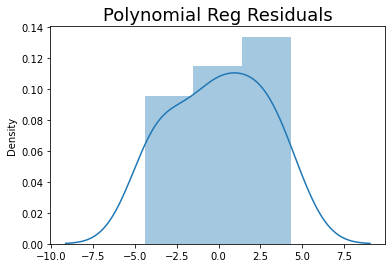

In [ ]:
y_hat = pipe.predict(X_train)
sns.distplot(y_train - y_hat)
plt.title("Polynomial Reg Residuals", size=18)
pipe.score(X_train,y_train)

We can see that the polynomial regression is more accurate than the linear by looking at the values of the residuals/root-mean-square deviations and the accuracy values. The accuracy values are higher in the polynomial fit, and the residual/root-mean-square values are lower in the polynomial fit.

#Conclusion

A number of different conclusions can be drawn from the data presented here. 

From a player's perspective, data here can be used to think about one's own gameplay strategies and how they can be improved. For example, one could look at the maps of player positions and use it to consider their own positioning and how it could be improved to counter other players' strategies.

One could also look at the map of common smoke grenade throws compared to a map of player positioning and use it to consider which smoke throws might be the most effective in countering common strategies. One could look at the map of smokes filteered by players above a certain rank and see what strategies are implemented by more experienced players which they could implement into their own gameplay.

A player could look at the analysis of different weapon matchup ranges and use that to determine which weapon to use when playing positions that will result in different ranges of engagement. For example, looking at the AWP vs Tec-9 matchup would show a player that they have better odds of defeating an AWP user with a Tec-9 if they are able to close the distance and engage from a close range. It could also indicate that if they choose to buy an AWP, they'd be well suited to also buy a secondary pistol that has good performance in ranges and matchups that the AWP might not be as effective in.

From a developer's perspective, this data also has a lot to demonstrate in terms of understanding player trends and how different mechanics effect gameplay. This data was collected years ago, and Valve's own analysis since then has resulted in changes to game mechanics. For example, look at the Sawed Off shotgun effective range. It is noticeably low range and ineffective in matchups against weapons that cost less and should be weaker. Valve has since implemented multiple range increases to this weapon that demonstrate how analyzing weapon data in this form can be useful in understanding how the weapon matchups work and what should be changed.

There are also a number of different analyses and conclusions that could be drawn from this dataset. For example, one could look at the prevalency of different maps. You could even check which maps are played most at different times. Maybe Dust 2 is played more often in winter months than in summer months? Maybe players at higher ranks play a map like Cache more often than players at lower ranks? We've only scratched the surface of this dataset's potential. Datapoints that we completely ignored like bomb site choice, defuses, etc all have ample opportunity for analysis. We encourage the readers to take our code and play around with different variables, filters, etc and see what interesting insights they can find. There was a number of different configurations we'd have liked to include yet were unable to due to not wanting to make our writeup unnecessarily long.

In [ ]:
%%shell
jupyter nbconvert --to html /content/index.ipynb

[NbConvertApp] Converting notebook /content/index.ipynb to html
[NbConvertApp] Writing 5403185 bytes to /content/index.html
